# Explore here

In [ ]:
!pip install statsmodels
!pip install category_encoders

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import xgboost as xgb
import seaborn as sns

In [4]:
#cogemos los datos de Airbnb de NYC que se encuentran en la carpeta de data / raw
df = pd.read_csv('../data/raw/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
#miramos su dimensión
df.shape

(48895, 16)

In [6]:
#nos sirve para visualizar el tipo de dato y tambien los datos null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
#vemos si hay columnas que solo tengan un valor
n_unicos = df.nunique()
n_unicos

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [8]:
#vemos si hay filas duplicadas
df.duplicated().sum()

np.int64(0)

In [9]:
#podemos ver con exactitud los datos qeu tenemos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.00000,9.471945e+06,1.967728e+07,2.915218e+07,3.648724e+07
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


In [10]:
#vemos la relacion de las reviews porque hay tres columnas de ello
df[['number_of_reviews', 'last_review', 'reviews_per_month']]

,number_of_reviews,last_review,reviews_per_month
0,9,2018-10-19,0.21
1,45,2019-05-21,0.38
2,0,NaN,NaN
3,270,2019-07-05,4.64
4,9,2018-11-19,0.10
...,...,...,...
48890,0,NaN,NaN
48891,0,NaN,NaN
48892,0,NaN,NaN
48893,0,NaN,NaN


In [ ]:
# borramos reviews_per_month y last_review, tampoco dan información relevante
#  ya que también tenemos number_of_reviews. Además tienen muchos nulls

In [11]:
df.drop(columns=['reviews_per_month','last_review'], inplace=True)

In [12]:
df.shape

(48895, 14)

In [13]:
#mirmaos si hay duplicados
df.T.duplicated(keep=False)

id                                False
name                              False
host_id                           False
host_name                         False
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [14]:
# name y host_name tampoco aportan valor porque al final son nombres y las borramos 
df.drop(columns=['name', 'host_name'], inplace=True)

In [15]:
#eliminamos las filas que no tiene disponibilidad ningún día y donde el precio es = 0 
df.drop(df[df['availability_365'] == 0].index, inplace=True)
df.drop(df[df['price'] == 0].index, inplace=True)

In [16]:
df.shape

(31354, 12)

In [17]:
#compruebo que no hay valores nulos
df.isnull().mean()*100

id                                0.0
host_id                           0.0
neighbourhood_group               0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

In [18]:
#borramos estas columnas y nos quedamos con neighbourhood_group, porque sino es redundante la informacion 
df.drop(columns=["neighbourhood", "latitude", "longitude"], inplace=True)

In [19]:
df

,id,host_id,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,2787,Brooklyn,Private room,149,1,9,6,365
1,2595,2845,Manhattan,Entire home/apt,225,1,45,2,355
2,3647,4632,Manhattan,Private room,150,3,0,1,365
3,3831,4869,Brooklyn,Entire home/apt,89,1,270,1,194
5,5099,7322,Manhattan,Entire home/apt,200,3,74,1,129
...,...,...,...,...,...,...,...,...,...
48890,36484665,8232441,Brooklyn,Private room,70,2,0,2,9
48891,36485057,6570630,Brooklyn,Private room,40,4,0,2,36
48892,36485431,23492952,Manhattan,Entire home/apt,115,10,0,1,27
48893,36485609,30985759,Manhattan,Shared room,55,1,0,6,2


In [24]:
df["room_type"].nunique()

3

In [25]:
df['neighbourhood_group'].nunique()

5

In [26]:
#hacemos onehotencoding con roomtype y neighbourhood_group, asi tenemos todos los datos en int
df_onehotencoding = pd.get_dummies(df, columns=['room_type', 'neighbourhood_group'], prefix='room', drop_first=True)
df = df_onehotencoding

In [27]:
#creamos una columna del logaritmo del precio
df['log_price'] = np.log(df.price)

In [28]:
df

,id,host_id,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_Private room,room_Shared room,room_Brooklyn,room_Manhattan,room_Queens,room_Staten Island,log_price
0,2539,2787,149,1,9,6,365,True,False,True,False,False,False,5.003946
1,2595,2845,225,1,45,2,355,False,False,False,True,False,False,5.416100
2,3647,4632,150,3,0,1,365,True,False,False,True,False,False,5.010635
3,3831,4869,89,1,270,1,194,False,False,True,False,False,False,4.488636
5,5099,7322,200,3,74,1,129,False,False,False,True,False,False,5.298317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,8232441,70,2,0,2,9,True,False,True,False,False,False,4.248495
48891,36485057,6570630,40,4,0,2,36,True,False,True,False,False,False,3.688879
48892,36485431,23492952,115,10,0,1,27,False,False,False,True,False,False,4.744932
48893,36485609,30985759,55,1,0,6,2,False,True,False,True,False,False,4.007333


In [35]:
#lo pasamos todo a int
df = df.astype(int)

In [36]:
X = df.drop(['log_price', 'price'], axis = 1)
y = df['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train.shape

(25083, 12)

In [38]:
X_test.shape

(6271, 12)

In [39]:
#observaciones influyentes
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()

In [40]:
cooks_distance = model.get_influence().cooks_distance[0]

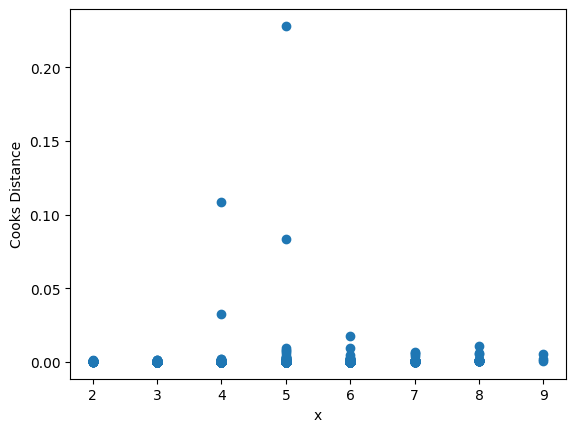

In [41]:
plt.scatter(y_train, cooks_distance)
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [42]:
pto_corte = 4/len(X_train)

In [43]:
idx_influyentes = np.where(cooks_distance>pto_corte)[0]
idx_influyentes

array([   16,    29,    66,    73,    88,    92,   100,   172,   175,
         222,   325,   336,   350,   380,   414,   423,   440,   472,
         487,   489,   574,   581,   600,   604,   663,   668,   673,
         678,   721,   726,   732,   736,   738,   785,   799,   805,
         825,   866,   913,   917,   931,   957,   978,   988,   999,
        1155,  1269,  1282,  1356,  1366,  1397,  1410,  1452,  1481,
        1485,  1493,  1499,  1515,  1519,  1525,  1549,  1675,  1704,
        1713,  1733,  1760,  1786,  1805,  1820,  1867,  1908,  1923,
        1948,  1980,  1984,  2039,  2056,  2100,  2165,  2191,  2196,
        2226,  2231,  2240,  2274,  2282,  2304,  2336,  2345,  2346,
        2353,  2355,  2359,  2362,  2379,  2381,  2388,  2412,  2427,
        2435,  2460,  2496,  2521,  2623,  2629,  2638,  2661,  2675,
        2685,  2781,  2804,  2806,  2835,  2838,  2999,  3015,  3036,
        3048,  3059,  3083,  3088,  3091,  3097,  3103,  3111,  3122,
        3145,  3163,

In [46]:
#QUITAMOS LAS VIVIENDAS DONDE HAY DATOS INFLUYENTES
X_train1 = X_train.loc[~X_train.index.isin(X_train.index[idx_influyentes]),:]
y_train1 = y_train.loc[~X_train.index.isin(X_train.index[idx_influyentes])]

In [50]:
#importancia de caracteristicas
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train1, y_train1)
dict_data = {'Feature': X_train1.columns,'Importancia': xgb_model.feature_importances_ * 100}
df_imp = pd.DataFrame(dict_data)
df_imp.sort_values(by='Importancia', ascending=False, inplace=True)

In [53]:
df_imp[df_imp['Importancia']>=1]

,Feature,Importancia
6,room_Private room,47.627754
7,room_Shared room,38.235123
9,room_Manhattan,7.782162
8,room_Brooklyn,1.321247


In [54]:
X_train1.drop(df_imp[df_imp['Importancia']<1]['Feature'], axis=1, inplace=True)
X_test.drop(df_imp[df_imp['Importancia']<1]['Feature'], axis=1, inplace=True)

/tmp/ipykernel_2386/244323815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train1.drop(df_imp[df_imp['Importancia']<1]['Feature'], axis=1, inplace=True)


In [55]:
X_train1.shape

(24173, 4)

<Axes: >

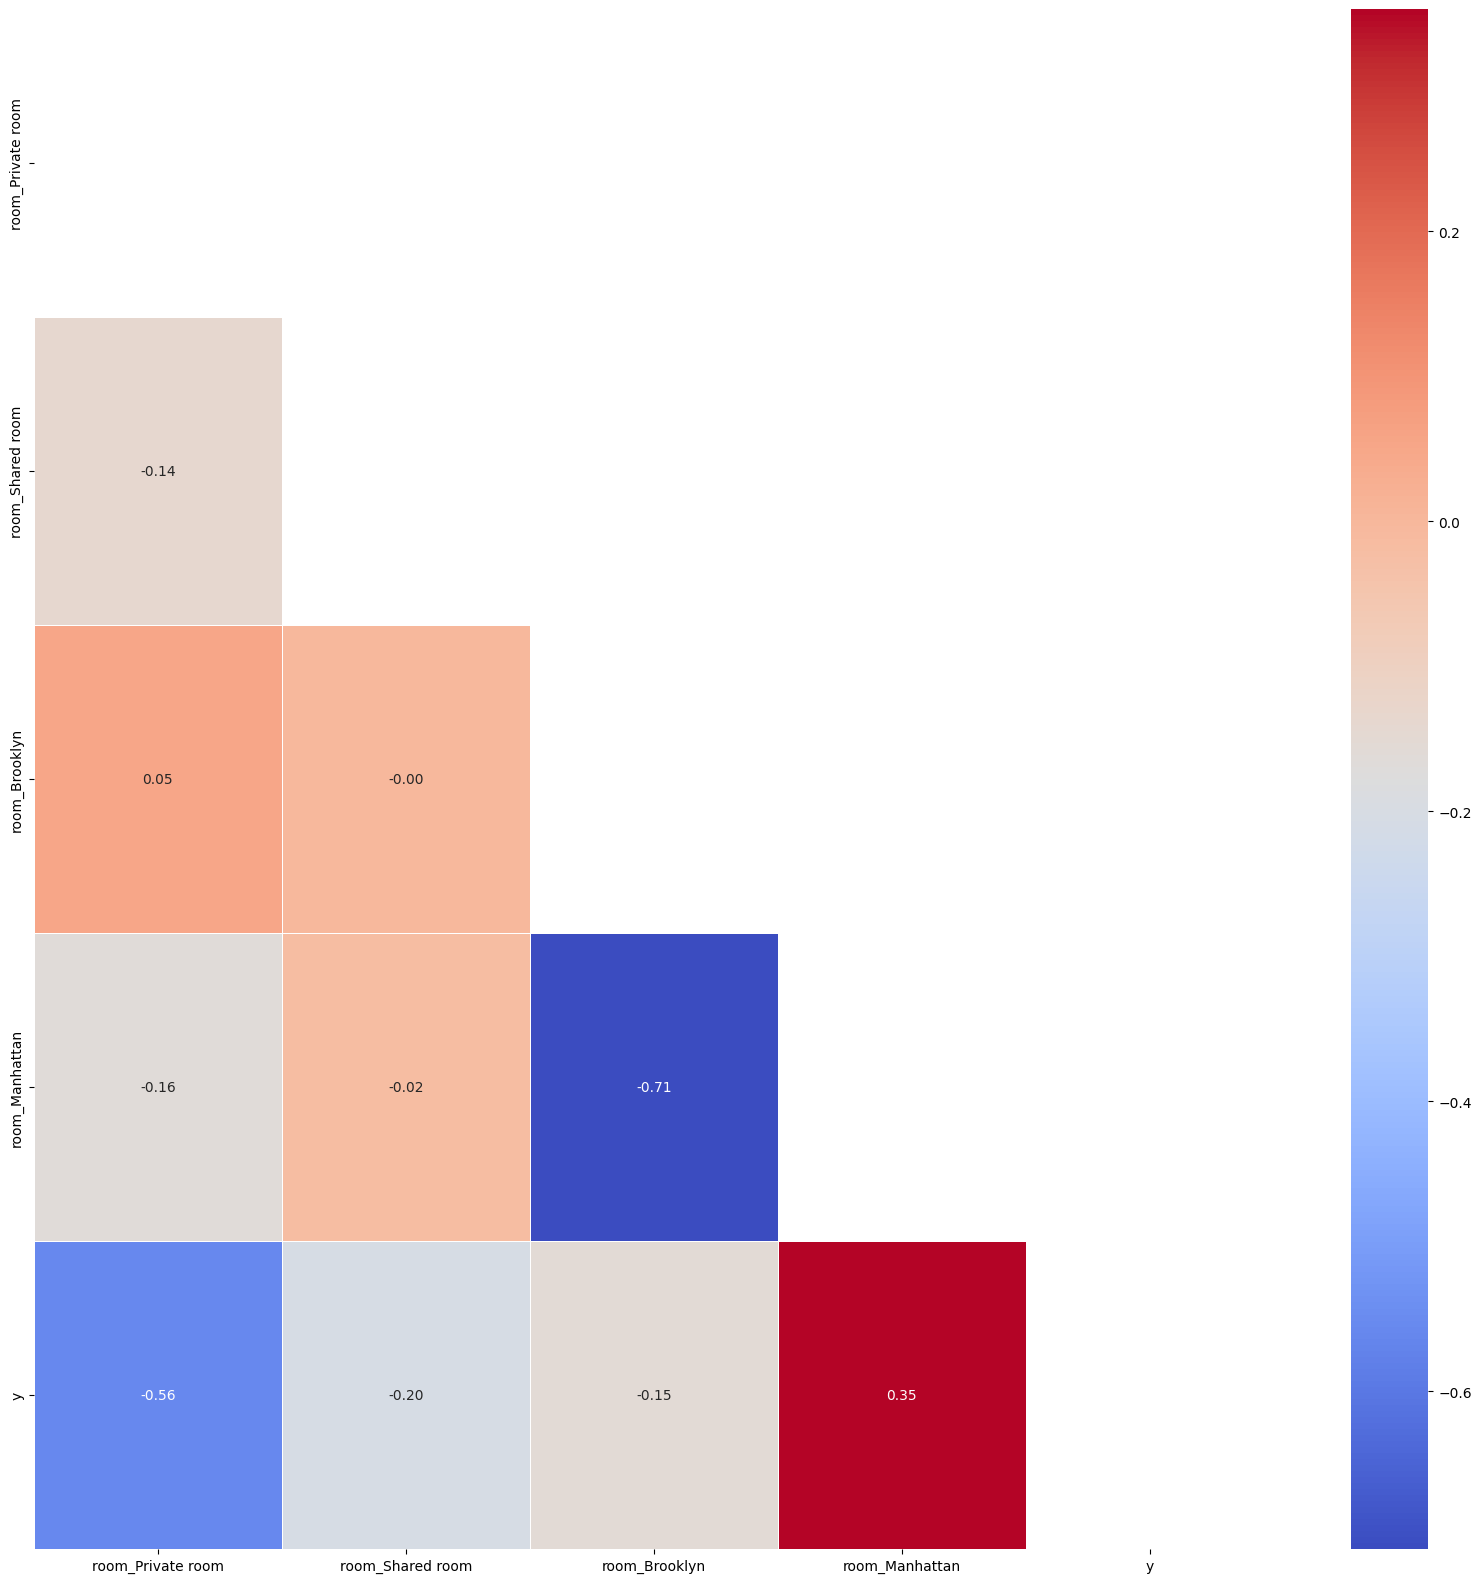

In [56]:
X_corr = X_train1.copy()
X_corr['y'] = y_train1
corr = X_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [57]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     1485.
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        16:53:53   Log-Likelihood:                -22387.
No. Observations:               25083   AIC:                         4.480e+04
Df Residuals:                   25070   BIC:                         4.490e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [58]:
X_train1.to_csv('../data/processed/x_train1.csv', index=False)
y_train1.to_csv('../data/processed/y_train1.csv', index=False)
X_test.to_csv('../data/processed/x_test.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)